In [1]:
%matplotlib widget

import h5py
from IPython.display import display
from skimage.measure import find_contours
from skimage.draw import polygon2mask
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

In [2]:
mouse = "cfm002mjr"
date = 240510
rec = 'meas01'

noisy_path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + rec + '/cG_unmixed_dFF.h5'
denoised_path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + rec + '/cG_unmixed_dFF_denoised.h5'

with h5py.File(noisy_path, 'r') as mov_file:
    specs = mov_file["specs"]
    fps = specs['fps'][()][0][0][0]
    raw_mask = specs["extra_specs"]["mask"][()][0]
    binning = specs["binning"][()][0][0][0]  # Extract binning factor

    # Extract raw outlines
    raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
    spaceorigin = specs["spaceorigin"][()].flatten()  # Load space origin
    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Select outlines (default all if not specified)
    outlines_nums = np.arange(raw_outlines.shape[2])  # Equivalent to 1:size(raw_outlines, 3)
    
    # Adjust outlines
    outlines = raw_outlines[:, :, outlines_nums] / binning
    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

with h5py.File(denoised_path, 'r') as mov_file:
    mov = mov_file['mov'][()]
    movie_full = np.nan_to_num(mov)


In [43]:
#stim_1 = movie_full[round(202*fps):round(204*fps)]
#stim_1 = movie_full[round(66*fps):round(68*fps)]
stim_1 = movie_full[round(312*fps):round(314.5*fps)]

movie=stim_1

# === Stimulus timing (relative to clip start) ===
#stim_start = 0.57099# 0.62       # seconds after start of movie
#stim_duration = 0.53709#0.55   # seconds
stim_start = 0.62       # seconds after start of movie
stim_duration = 0.55    # seconds
stim_start = 1.181
stim_duration = 0.527

stim_start_frame = int(stim_start * fps)
stim_end_frame = int((stim_start + stim_duration) * fps)

In [44]:
# === Setup ===
i = 37  # V1 index
movie_shape = movie.shape[1:3]  # (height, width)

# Generate mask and contours
total_mask = np.zeros(movie_shape, dtype=bool)
outline = outlines[i, :, :]
valid_indices = ~np.isnan(outline).any(axis=0)
x_coords = outline[1, valid_indices]
y_coords = outline[0, valid_indices]

roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
roi_mask = np.flipud(roi_mask).astype(bool)
total_mask |= roi_mask
contours = find_contours(total_mask, level=0.5)

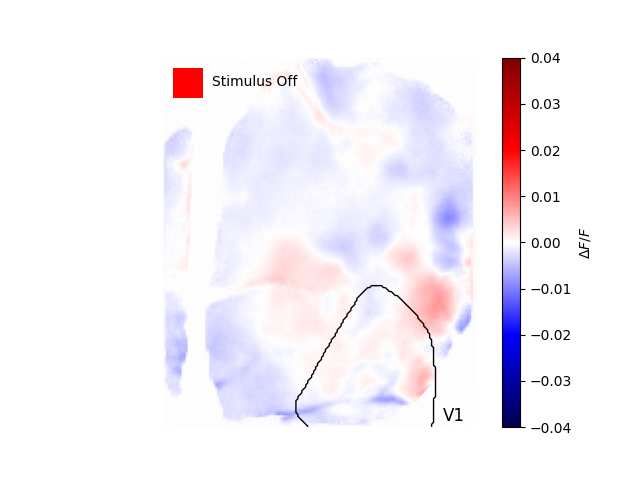

In [45]:
def play_movie_with_stimulus(movie, fps, stim_start_frame, stim_end_frame, contours):
    T, H, W = movie.shape

    fig, ax = plt.subplots()
    im = ax.imshow(movie[0], cmap='seismic', vmin=-0.04, vmax=0.04, animated=True)
    cbar = fig.colorbar(im, ax=ax, label=r'$\Delta F/F$')

    ax.axis('off')  # Hide axes for a cleaner look

    # Add a rectangle patch in top-left corner
    stim_rect = Rectangle((5, 5), 15, 15, facecolor='red')
    ax.add_patch(stim_rect)

    # Add text next to the rectangle
    stim_text = ax.text(25, 12, 'Stimulus Off', color='black', fontsize=10, verticalalignment='center')

    v1_text = ax.text(142, 182, 'V1', color='black', fontsize=12, verticalalignment='center')

    # Add contours
    lines = []
    for contour in contours:
        line, = ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1)
        lines.append(line)

    def update(frame):
        im.set_array(movie[frame])

        if stim_start_frame <= frame < stim_end_frame:
            stim_rect.set_facecolor('green')
            stim_text.set_text('Stimulus On')
        else:
            stim_rect.set_facecolor('red')
            stim_text.set_text('Stimulus Off')

        return [im, stim_rect, stim_text]

    ani = animation.FuncAnimation(
        fig, update, frames=T, interval=1000/fps, blit=True
    )
    
    ani.save("voltage_movie_3.gif", fps=fps, dpi=150, writer="pillow")

    plt.show()

plt.close('all')
play_movie_with_stimulus(movie, fps/5, stim_start_frame, stim_end_frame, contours)